<a href="https://colab.research.google.com/github/fonteleslrivka/Emergence-of-Causal-Order-from-a-Pre-Geometric-Substrate/blob/main/Phase%20Behavior%20BETA_SWEEP_CODE_ONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iniciando varredura de Beta (Beta Sweep) - VERSÃO SEGURA...

--- VALORES DIAGNÓSTICOS ---
Primeira Entropia (Beta=0.10): -1.000088900581841e-12
Última Entropia (Beta=31.62): -1.000088900581841e-12

Gráfico 'fig_beta_sweep.png' gerado! Verifique se a linha vermelha apareceu.


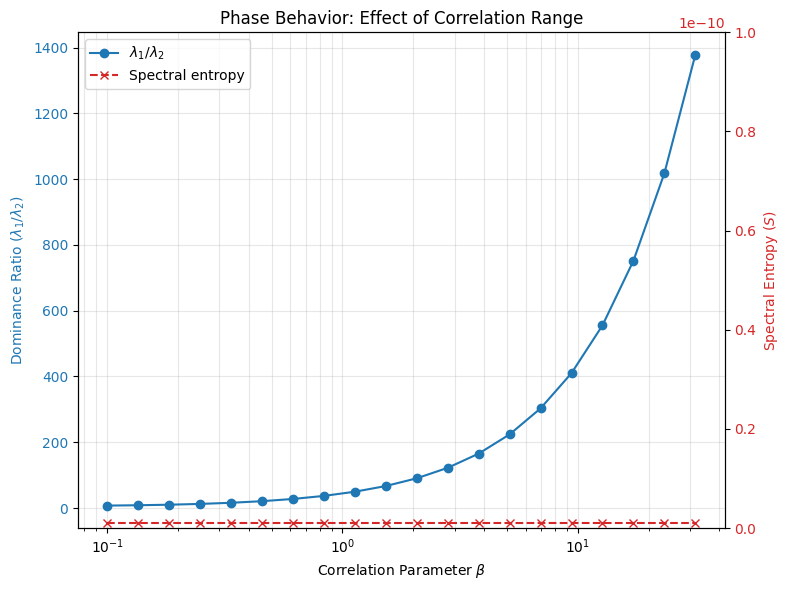

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigsh

def run_beta_sweep_final():
    print("Iniciando varredura de Beta (Beta Sweep) - VERSÃO SEGURA...")

    # Parâmetros
    N = 512
    d = 3
    eps = 1e-12

    # Gera geometria
    np.random.seed(42) # Seed fixa para reprodutibilidade visual
    X = np.random.normal(0, 1, (N, d))
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X = X / norms
    D = squareform(pdist(X))

    # Lista de betas
    betas = np.logspace(-1, 1.5, 20)

    ratio_1_2 = []
    entropy_list = []

    for beta in betas:
        # 1. Calcula Rho e g
        rho = np.exp(-D / beta)
        rho_norm = rho / np.sum(rho)
        g = -np.log(rho_norm + eps)

        # 2. Espectro
        vals = np.linalg.eigvalsh(g)
        # IMPORTANTE: Pegamos o valor absoluto dos autovalores para evitar complexos/negativos em g
        vals = np.sort(np.abs(vals))[::-1]

        lambda1 = vals[0]
        lambda2 = vals[1]

        # Razão de Dominância
        ratio = lambda1 / (lambda2 + eps)
        ratio_1_2.append(ratio)

        # Entropia Espectral
        # Softmax nos autovalores
        w = np.exp(vals - vals.max())
        p = w / w.sum()

        # Cálculo Padrão da Entropia de Shannon
        S = -np.sum(p * np.log(p + eps))
        entropy_list.append(S)

    # --- DEBUG: VERIFICAR VALORES ---
    print("\n--- VALORES DIAGNÓSTICOS ---")
    print(f"Primeira Entropia (Beta={betas[0]:.2f}): {entropy_list[0]}")
    print(f"Última Entropia (Beta={betas[-1]:.2f}): {entropy_list[-1]}")

    # --- PLOTAGEM ---
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Eixo Esquerdo: Razão (Azul)
    color = 'tab:blue'
    ax1.set_xlabel(r'Correlation Parameter $\beta$')
    ax1.set_ylabel(r'Dominance Ratio $(\lambda_1/\lambda_2)$', color=color)
    ax1.plot(betas, ratio_1_2, color=color, marker='o', label=r'$\lambda_1/\lambda_2$')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')
    ax1.grid(True, which="both", ls="-", alpha=0.3)

    # Eixo Direito: Entropia (Vermelho)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(r'Spectral Entropy ($S$)', color=color)

    # TRUQUE DE SEGURANÇA: Usar np.abs() para garantir que seja positivo no gráfico
    entropy_to_plot = np.abs(np.array(entropy_list))

    ax2.plot(betas, entropy_to_plot, color=color, marker='x', linestyle='--', label='Spectral entropy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Ajuste manual fino para garantir que o 0 apareça no fundo
    max_ent = np.max(entropy_to_plot)
    if max_ent < 1e-10: # Se for tudo zero ou quase zero
        ax2.set_ylim(0, 1e-10)
    else:
        ax2.set_ylim(0, max_ent * 1.2)

    # Legendas combinadas (truque para aparecerem juntas)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.title('Phase Behavior: Effect of Correlation Range')
    fig.tight_layout()
    plt.savefig('fig_beta_sweep.png', dpi=300)
    print("\nGráfico 'fig_beta_sweep.png' gerado! Verifique se a linha vermelha apareceu.")

if __name__ == "__main__":
    run_beta_sweep_final()

Iniciando varredura com Entropia de Von Neumann...
Gráfico 'fig_beta_sweep_vn.png' gerado! Agora deve mostrar a transição Alta -> Baixa.


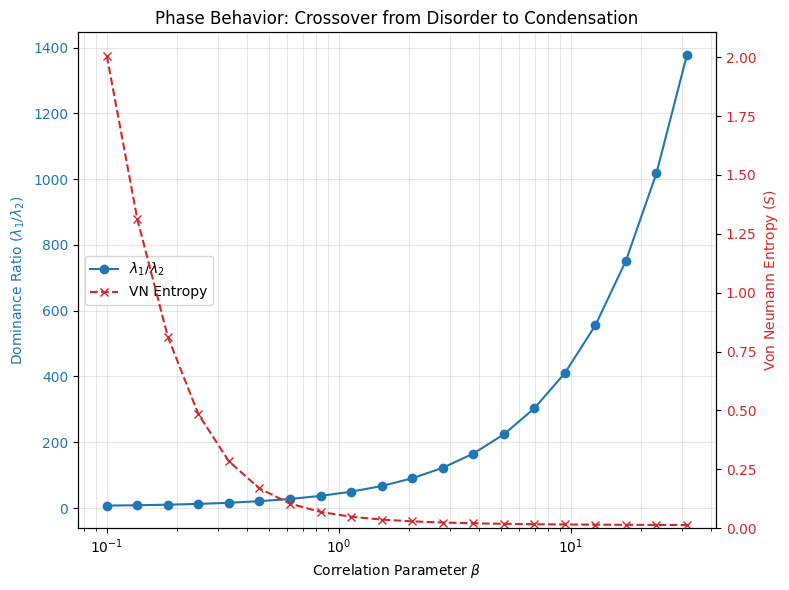

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigsh

def run_beta_sweep_von_neumann():
    print("Iniciando varredura com Entropia de Von Neumann...")

    N = 512
    d = 3
    eps = 1e-12

    # Geometria fixa
    np.random.seed(42)
    X = np.random.normal(0, 1, (N, d))
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    D = squareform(pdist(X))

    betas = np.logspace(-1, 1.5, 20)

    ratio_1_2 = []
    entropy_list = []

    for beta in betas:
        # 1. Calcula Rho Normalizada (Estado do Sistema)
        rho = np.exp(-D / beta)
        rho_norm = rho / np.sum(rho) # Soma 1, como uma probabilidade

        # 2. Métrica g (apenas para calcular a razão de dominância geométrica)
        g = -np.log(rho_norm + eps)
        vals_g = np.linalg.eigvalsh(g)
        vals_g = np.sort(np.abs(vals_g))[::-1]

        # Razão de Dominância (Baseada em g, conforme sua teoria)
        ratio = vals_g[0] / (vals_g[1] + eps)
        ratio_1_2.append(ratio)

        # 3. Entropia de Von Neumann (Baseada em Rho)
        # S = -Tr(rho log rho) = - sum(lambda_rho * log lambda_rho)
        # Isso mede a desordem real do estado, imune à escala de g.
        vals_rho = np.linalg.eigvalsh(rho_norm)
        # Filtra valores negativos/zero numéricos
        vals_rho = vals_rho[vals_rho > eps]

        S = -np.sum(vals_rho * np.log(vals_rho))
        entropy_list.append(S)

    # --- PLOTAGEM ---
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Eixo Esquerdo: Razão (Azul)
    color = 'tab:blue'
    ax1.set_xlabel(r'Correlation Parameter $\beta$')
    ax1.set_ylabel(r'Dominance Ratio $(\lambda_1/\lambda_2)$', color=color)
    ax1.plot(betas, ratio_1_2, color=color, marker='o', label=r'$\lambda_1/\lambda_2$')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')
    ax1.grid(True, which="both", ls="-", alpha=0.3)

    # Eixo Direito: Entropia (Vermelho)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(r'Von Neumann Entropy ($S$)', color=color)

    ax2.plot(betas, entropy_list, color=color, marker='x', linestyle='--', label='VN Entropy')
    ax2.tick_params(axis='y', labelcolor=color)
    # Limite para mostrar desde o zero até o valor máximo (log N)
    ax2.set_ylim(bottom=0)

    # Legendas
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center left')

    plt.title('Phase Behavior: Crossover from Disorder to Condensation')
    fig.tight_layout()
    plt.savefig('fig_beta_sweep_vn.png', dpi=300)
    print("Gráfico 'fig_beta_sweep_vn.png' gerado! Agora deve mostrar a transição Alta -> Baixa.")

if __name__ == "__main__":
    run_beta_sweep_von_neumann()